# Pre-process ESA Snow CCI data

- Snow Cover Fraction Climate Research Data Package: http://snow-cci.enveo.at/
- summer path: `/mnt/lalandmi/equipes/C2H/ESA_CCI_SNOW`

Check missing values, linear interpolation on time, and spatial aggregation

conda env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/lalandmi/Dropbox/Thèse/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


In [3]:
path_snow_CCI = '/mnt/lalandmi/equipes/C2H/ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg'
path_AVHRR = path_snow_CCI+'/AVHRR_MERGED/v2.0'
path_MODIS = path_snow_CCI+'/MODIS/v2.0'

In [46]:
ds = xr.open_dataset(path_AVHRR+'/1982/01/19820101-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc')
ds

<xarray.Dataset>
Dimensions:      (lat: 3600, lon: 7200, nv: 2, time: 1)
Coordinates:
  * time         (time) datetime64[ns] 1982-01-01
  * lat          (lat) float64 -89.97 -89.93 -89.88 -89.82 ... 89.88 89.93 89.97
  * lon          (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
Dimensions without coordinates: nv
Data variables:
    lat_bnds     (lat, nv) float64 ...
    lon_bnds     (lon, nv) float64 ...
    scfg         (time, lat, lon) float32 ...
    scfg_unc     (time, lat, lon) float32 ...
    spatial_ref  int32 ...
Attributes:
    title:                      ESA CCI snow on ground product level L3C dail...
    institution:                Remote Sensing Research Group, Institute of G...
    source:                     AVHRR_NOAA-7_GAC mosaic from ESA Cloud CCI pr...
    date_created:               20211109T162200Z
    history:                    20211109T162200Z: ESA snow_cci SCF processing...
    references:                 http://snow-cci.enveo.at/
    tracking_id:                afb79860-80e9-43f0-9a4c-d798cc7845d5
    Conventions:                CF-1.9
    product_version:            2.0
    format_version:             CCI Data Standards v2.3
    summary:                    The SCFG product provides daily information o...
    keywords:                   snow, cover, AVHRR
    id:                         19820101-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv...
    naming_authority:           ch.unibe
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    cdm_data_type:              Grid
    comment:                    The following auxiliary data sets are used fo...
    creator_name:               Remote Sensing Research Group
    creator_url:                http://giub.unibe.ch
    creator_email:              snow_CCI_AVHRR@giub.unibe.ch
    project:                    Climate Change Initiative - European Space Ag...
    geospatial_lat_min:         -90
    geospatial_lat_max:         90
    geospatial_lon_min:         -180
    geospatial_lon_max:         180
    geospatial_vertical_min:    0
    geospatial_vertical_max:    0
    geospatial_lon_resolution:  0.05
    geospatial_lat_resolution:  0.05
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    time_coverage_start:        19820101T000000Z
    time_coverage_end:          19820101T235959Z
    time_coverage_duration:     P1D
    time_coverage_resolution:   P1D
    standard_name_vocabulary:   CF Standard Name Table v78
    license:                    ESA CCI Data Policy: free and open access
    platform:                   NOAA-7
    sensor:                     AVHRR
    spatial_resolution:         0.05 degree
    key_variables:              scfg
    doi:                        10.5285/3f034f4a08854eb59d58e1fa92d207b6

## Flag_values
- 205: Cloud
- 206: Polar_Night_or_Night
- 210: Water
- 215: Permanent_Snow_and_Ice 
- 254: No_Satellit

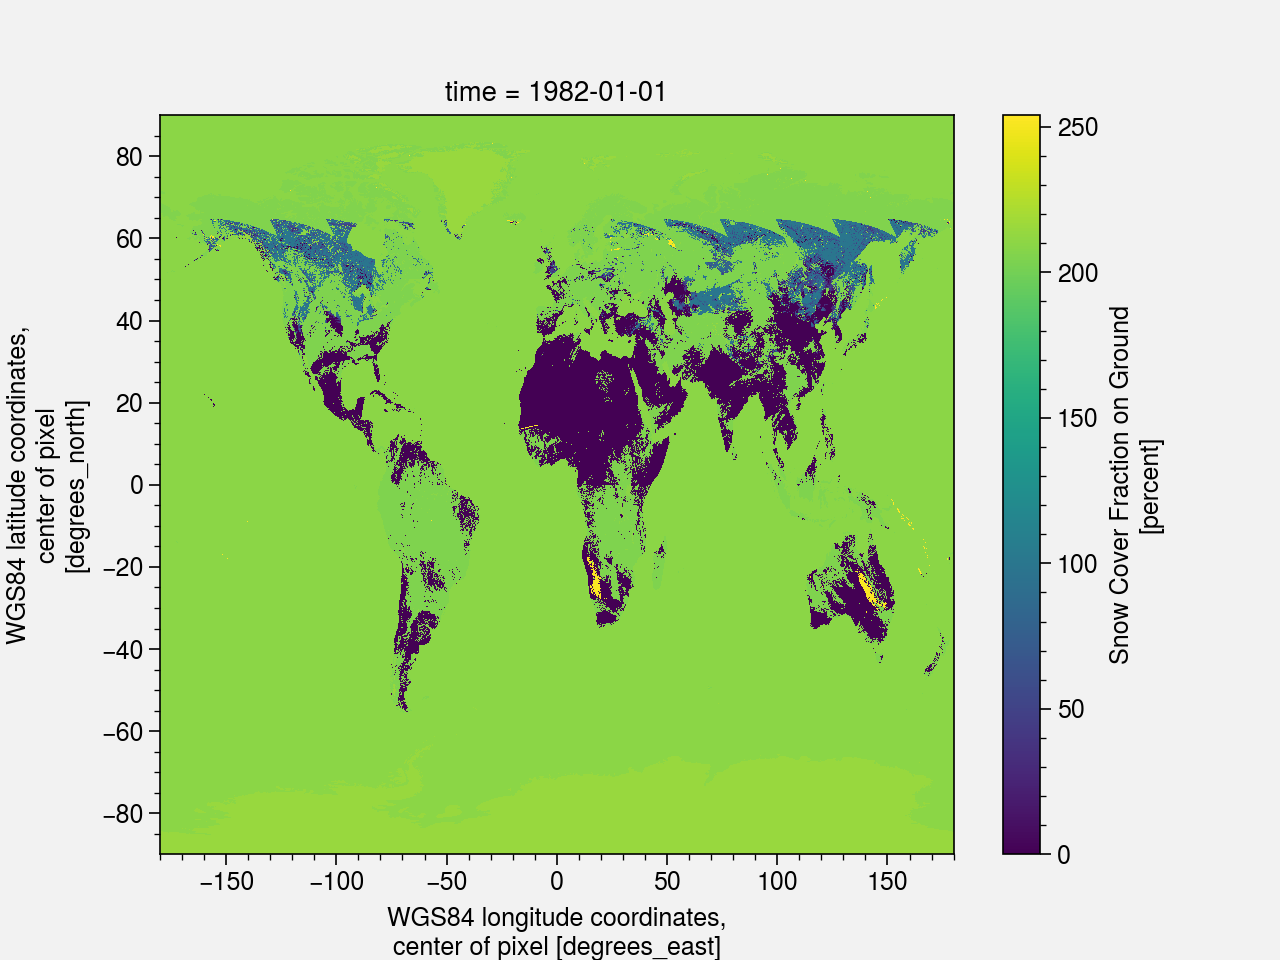

In [7]:
ds.scfg[0].plot()

In [67]:
latlim = slice(0, 90)
lonlim = slice(-180, 180)

scf = da.where(da <= 100).sel(lat=latlim, lon=lonlim)

scf_snow = scf.where(scf > 0).sel(lat=latlim, lon=lonlim)

nan_No_Snow = da.where(scf == 0).sel(lat=latlim, lon=lonlim)
nan_No_Snow.name = 'No_Snow'
nan_No_Snow.attrs['color'] = 'bisque'

nan_Cloud = da.where(da == 205)
nan_Cloud.name = 'Cloud'
nan_Cloud.attrs['color'] = 'cloudy blue'

nan_Polar_Night_or_Night = da.where(da == 206).sel(lat=latlim, lon=lonlim)
nan_Polar_Night_or_Night.name = 'Polar_Night_or_Night'
nan_Polar_Night_or_Night.attrs['color'] = 'midnight'

nan_Water = da.where(da == 210).sel(lat=latlim, lon=lonlim)
nan_Water.name = 'Water'
nan_Water.attrs['color'] = 'pale blue'

nan_Permanent_Snow_and_Ice = da.where(da == 215).sel(lat=latlim, lon=lonlim)
nan_Permanent_Snow_and_Ice.name = 'Permanent_Snow_and_Ice'
nan_Permanent_Snow_and_Ice.attrs['color'] = 'baby blue'

nan_No_Satellit = da.where(da == 254).sel(lat=latlim, lon=lonlim)
nan_No_Satellit.name = 'No_Satellit'
nan_No_Satellit.attrs['color'] = 'gray7'

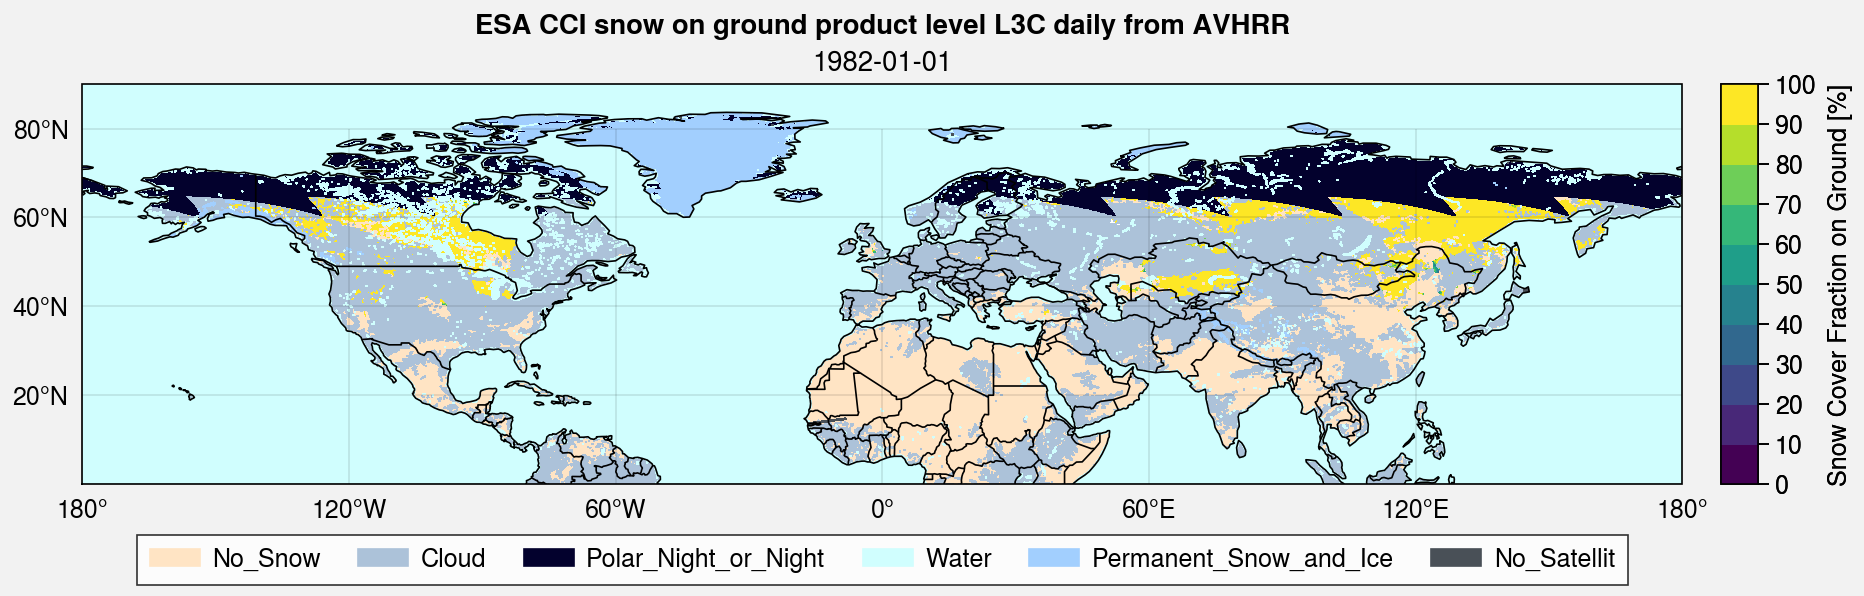

In [68]:
import matplotlib.patches as mpatches

fig, axs = plot.subplots(proj='cyl', axwidth=8, nrows=1)

m = axs[0].contourf(scf_snow, cmap='viridis', levels=plot.arange(0,100,10), extend='neither')
axs[0].colorbar(m, label=scf.long_name + ' [%]')
axs[0].format(title=str(scf.time.values)[:10])

nans = [nan_No_Snow, nan_Cloud, nan_Polar_Night_or_Night, nan_Water, nan_Permanent_Snow_and_Ice, nan_No_Satellit]
patches = []

for i, da_nan in enumerate(nans):
    if np.count_nonzero(~da_nan.isnull()) != 0:
        axs[0].contourf(da_nan, color=da_nan.color)
        p = mpatches.Patch(color=da_nan.color, label=da_nan.name)
        patches.append(p)

axs[0].legend(patches, loc='b', ncols=len(patches))

axs.format(
    labels=True, grid=True, coast=True, borders=True,
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    ocean=True, oceancolor=nan_Water.color,
    suptitle=ds.title
)